Epoch 1000, Total Loss: 0.000463, Data Loss: 0.000462, Physics Loss: 0.077438
Epoch 2000, Total Loss: 0.000002, Data Loss: 0.000002, Physics Loss: 0.002302
Epoch 3000, Total Loss: 0.000106, Data Loss: 0.000106, Physics Loss: 0.006342
Epoch 4000, Total Loss: 0.000007, Data Loss: 0.000007, Physics Loss: 0.001047
Epoch 5000, Total Loss: 0.000045, Data Loss: 0.000045, Physics Loss: 0.001206
Epoch 6000, Total Loss: 0.000004, Data Loss: 0.000004, Physics Loss: 0.000546
Epoch 7000, Total Loss: 0.000111, Data Loss: 0.000111, Physics Loss: 0.000333
Epoch 8000, Total Loss: 0.000001, Data Loss: 0.000001, Physics Loss: 0.000187
Epoch 9000, Total Loss: 0.000041, Data Loss: 0.000041, Physics Loss: 0.000170
Epoch 10000, Total Loss: 0.000002, Data Loss: 0.000002, Physics Loss: 0.000210
Epoch 11000, Total Loss: 0.000034, Data Loss: 0.000034, Physics Loss: 0.000223
Epoch 12000, Total Loss: 0.000286, Data Loss: 0.000286, Physics Loss: 0.000212
Epoch 13000, Total Loss: 0.000011, Data Loss: 0.000011, Physi

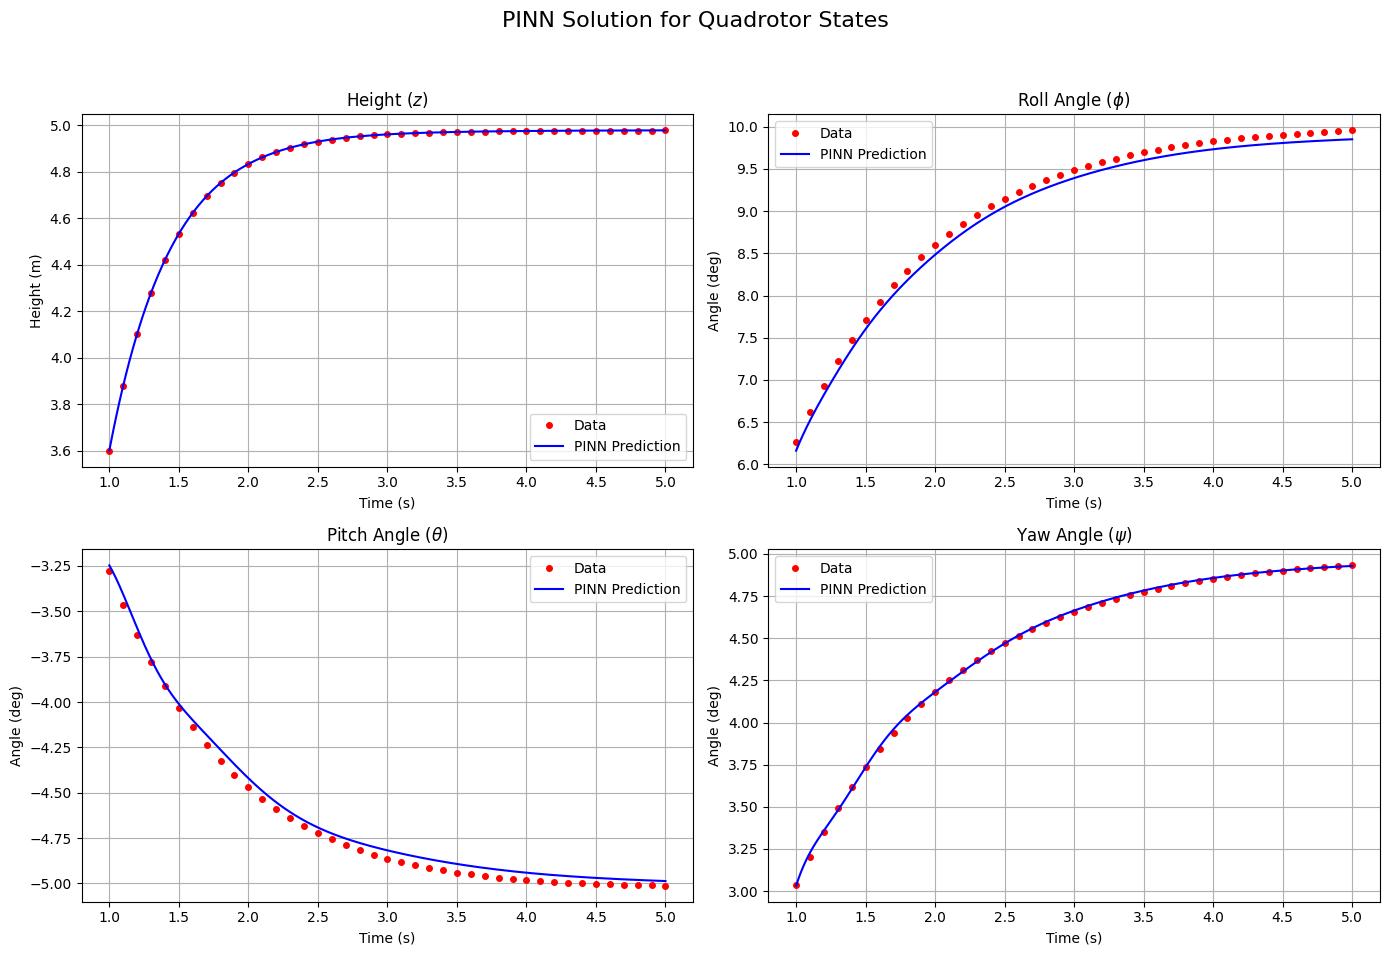

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data ---
data = pd.read_csv('quad_normal.csv')

# Time data needs to track gradients for derivative calculations
t_data = torch.tensor(data['Time_s'].values, dtype=torch.float32).view(-1, 1)
t_data.requires_grad = True

# Load the required data columns (z, phi, theta, psi)
h_data = torch.tensor(data['Height_m'].values, dtype=torch.float32).view(-1, 1)
z_data = -h_data  # In your model, z is negative height

phi_data = torch.tensor(data['Roll_deg'].values * np.pi / 180.0, dtype=torch.float32).view(-1, 1)
theta_data = torch.tensor(data['Pitch_deg'].values * np.pi / 180.0, dtype=torch.float32).view(-1, 1)
psi_data = torch.tensor(data['Yaw_deg'].values * np.pi / 180.0, dtype=torch.float32).view(-1, 1)

# --- 2. Define the PINN Model ---
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            # Outputs: z, phi, theta, psi, u, v, w
            nn.Linear(128, 7)
        )

    def forward(self, t):
        return self.net(t)

pinn_model = PINN()

# --- 3. Define the Physics-Informed Loss ---
def physics_loss(model, t):
    predictions = model(t)
    z, phi, theta = predictions[:, 0:1], predictions[:, 1:2], predictions[:, 2:3]
    u, v, w = predictions[:, 4:5], predictions[:, 5:6], predictions[:, 6:7]

    z_t = torch.autograd.grad(z, t, grad_outputs=torch.ones_like(z), create_graph=True)[0]
    
    # z_dot = -(-sin(theta)*u + cos(theta)*sin(phi)*v + cos(theta)*cos(phi)*w)
    f_z = z_t + (-torch.sin(theta)*u + torch.cos(theta)*torch.sin(phi)*v + torch.cos(theta)*torch.cos(phi)*w)
    
    return torch.mean(torch.square(f_z))

# --- 4. Training ---
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)
epochs = 15000  # Rerunning training
mse_data_loss = nn.MSELoss()

for epoch in range(epochs):
    optimizer.zero_grad()

    preds = pinn_model(t_data)
    z_pred, phi_pred, theta_pred, psi_pred = preds[:, 0:1], preds[:, 1:2], preds[:, 2:3], preds[:,3:4]

    loss_data = mse_data_loss(z_pred, z_data) + \
                mse_data_loss(phi_pred, phi_data) + \
                mse_data_loss(theta_pred, theta_data) + \
                mse_data_loss(psi_pred, psi_data)

    loss_phys = physics_loss(pinn_model, t_data)
    total_loss = loss_data + 1e-5 * loss_phys
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1}, Total Loss: {total_loss.item():.6f}, Data Loss: {loss_data.item():.6f}, Physics Loss: {loss_phys.item():.6f}')

# --- 5. Plotting All Four States ---
t_plot = torch.linspace(t_data.min(), t_data.max(), 500).view(-1, 1)
pinn_model.eval()
with torch.no_grad():
    predictions_plot = pinn_model(t_plot)

# Convert all necessary tensors to numpy for plotting
t_np = t_data.detach().numpy()
h_np = h_data.detach().numpy()
phi_np = phi_data.detach().numpy() * 180 / np.pi
theta_np = theta_data.detach().numpy() * 180 / np.pi
psi_np = psi_data.detach().numpy() * 180 / np.pi

t_plot_np = t_plot.numpy()
h_plot_np = -predictions_plot[:, 0].numpy()
phi_plot_np = predictions_plot[:, 1].numpy() * 180 / np.pi
theta_plot_np = predictions_plot[:, 2].numpy() * 180 / np.pi
psi_plot_np = predictions_plot[:, 3].numpy() * 180 / np.pi

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PINN Solution for Quadrotor States', fontsize=16)

# Height (z) plot
axs[0, 0].plot(t_np, h_np, 'ro', label='Data', markersize=4)
axs[0, 0].plot(t_plot_np, h_plot_np, 'b-', label='PINN Prediction')
axs[0, 0].set_title('Height ($z$)')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Height (m)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Roll (phi) plot
axs[0, 1].plot(t_np, phi_np, 'ro', label='Data', markersize=4)
axs[0, 1].plot(t_plot_np, phi_plot_np, 'b-', label='PINN Prediction')
axs[0, 1].set_title('Roll Angle ($\\phi$)')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Angle (deg)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Pitch (theta) plot
axs[1, 0].plot(t_np, theta_np, 'ro', label='Data', markersize=4)
axs[1, 0].plot(t_plot_np, theta_plot_np, 'b-', label='PINN Prediction')
axs[1, 0].set_title('Pitch Angle ($\\theta$)')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Angle (deg)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Yaw (psi) plot
axs[1, 1].plot(t_np, psi_np, 'ro', label='Data', markersize=4)
axs[1, 1].plot(t_plot_np, psi_plot_np, 'b-', label='PINN Prediction')
axs[1, 1].set_title('Yaw Angle ($\\psi$)')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Angle (deg)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Epoch     0 | Total Loss = 22.853470 | Data = 22.853470 | PDE = 0.000547 | c1=-0.0006, c2=-0.0005, c3=-0.0004, c4=0.0006
Epoch   500 | Total Loss = 0.006046 | Data = 0.006046 | PDE = 0.001703 | c1=-0.2858, c2=-0.2359, c3=0.2429, c4=0.2380
Epoch  1000 | Total Loss = 0.000049 | Data = 0.000048 | PDE = 0.010214 | c1=-0.2048, c2=-0.1596, c3=0.3154, c4=0.2930
Epoch  1500 | Total Loss = 0.000015 | Data = 0.000015 | PDE = 0.006437 | c1=-0.1533, c2=-0.0663, c3=0.5455, c4=0.4785
Epoch  2000 | Total Loss = 0.000010 | Data = 0.000010 | PDE = 0.002722 | c1=-0.1088, c2=0.0229, c3=0.7619, c4=0.6572
Epoch  2500 | Total Loss = 0.000006 | Data = 0.000006 | PDE = 0.000861 | c1=-0.0742, c2=0.0960, c3=0.9301, c4=0.7982
Epoch  3000 | Total Loss = 0.000003 | Data = 0.000003 | PDE = 0.000191 | c1=-0.0517, c2=0.1477, c3=1.0401, c4=0.8909
Epoch  3500 | Total Loss = 0.000002 | Data = 0.000002 | PDE = 0.000034 | c1=-0.0407, c2=0.1790, c3=1.0969, c4=0.9386
Epoch  4000 | Total Loss = 0.000001 | Data = 0.000001 | P

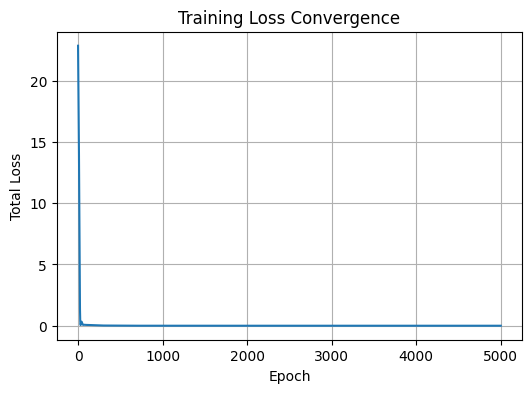

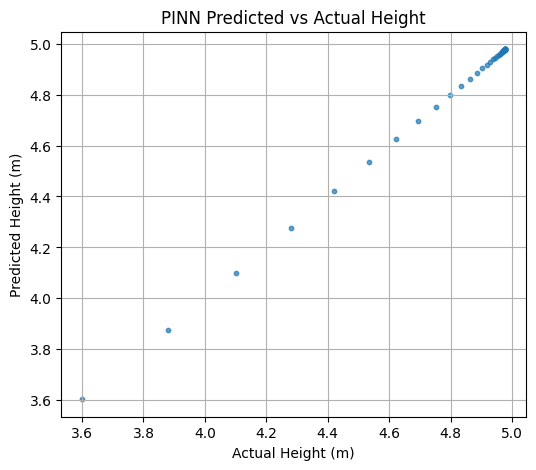


Discovered PDE Coefficients:
c1 (z_xx term): -0.040789
c2 (z_yy term): 0.219329
c3 (z_x term):  1.124726
c4 (z_y term):  0.961634


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ Load and preprocess data
# ============================================================
data = pd.read_csv('quad_normal.csv')

# Extract columns
t = data['Time_s'].values.reshape(-1, 1)
x = data['X_m'].values.reshape(-1, 1)
y = data['Y_m'].values.reshape(-1, 1)
z = data['Height_m'].values.reshape(-1, 1)

# Normalize inputs for stable training
t_min, t_max = t.min(), t.max()
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

t_norm = (t - t_min) / (t_max - t_min)
x_norm = (x - x_min) / (x_max - x_min)
y_norm = (y - y_min) / (y_max - y_min)

# Convert to torch tensors
t_torch = torch.tensor(t_norm, dtype=torch.float32, requires_grad=True)
x_torch = torch.tensor(x_norm, dtype=torch.float32, requires_grad=True)
y_torch = torch.tensor(y_norm, dtype=torch.float32, requires_grad=True)
z_torch = torch.tensor(z, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t_torch, x_torch, y_torch, z_torch = (
    t_torch.to(device),
    x_torch.to(device),
    y_torch.to(device),
    z_torch.to(device)
)

# ============================================================
# 2️⃣ Define Neural Network + Learnable PDE coefficients
# ============================================================
class PDE_Net(nn.Module):
    def __init__(self, layers=[3, 64, 64, 64, 64, 1]):
        super(PDE_Net, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

        # Learnable PDE coefficients
        self.c1 = nn.Parameter(torch.tensor(0.0))  # coefficient for z_xx
        self.c2 = nn.Parameter(torch.tensor(0.0))  # coefficient for z_yy
        self.c3 = nn.Parameter(torch.tensor(0.0))  # coefficient for z_x
        self.c4 = nn.Parameter(torch.tensor(0.0))  # coefficient for z_y

    def forward(self, t, x, y):
        inputs = torch.cat((t, x, y), dim=1)
        for i in range(len(self.layers) - 1):
            inputs = self.activation(self.layers[i](inputs))
        return self.layers[-1](inputs)


# ============================================================
# 3️⃣ Initialize model and optimizer
# ============================================================
model = PDE_Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# ============================================================
# 4️⃣ Define combined loss function
# ============================================================
def pinn_loss(t, x, y, z_true):
    z_pred = model(t, x, y)

    # Compute derivatives
    z_t = torch.autograd.grad(z_pred, t, grad_outputs=torch.ones_like(z_pred),
                              retain_graph=True, create_graph=True)[0]
    z_x = torch.autograd.grad(z_pred, x, grad_outputs=torch.ones_like(z_pred),
                              retain_graph=True, create_graph=True)[0]
    z_y = torch.autograd.grad(z_pred, y, grad_outputs=torch.ones_like(z_pred),
                              retain_graph=True, create_graph=True)[0]
    z_xx = torch.autograd.grad(z_x, x, grad_outputs=torch.ones_like(z_x),
                               retain_graph=True, create_graph=True)[0]
    z_yy = torch.autograd.grad(z_y, y, grad_outputs=torch.ones_like(z_y),
                               retain_graph=True, create_graph=True)[0]

    # PDE residual: z_t - (c1*z_xx + c2*z_yy + c3*z_x + c4*z_y) = 0
    f_pde = z_t - (model.c1 * z_xx + model.c2 * z_yy + model.c3 * z_x + model.c4 * z_y)

    # Data loss + PDE loss
    loss_data = torch.mean((z_pred - z_true) ** 2)
    loss_pde = torch.mean(f_pde ** 2)

    # Combined total loss
    total_loss = loss_data + 1e-5 * loss_pde
    return total_loss, loss_data, loss_pde


# ============================================================
# 5️⃣ Training loop
# ============================================================
epochs = 5000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss, loss_data, loss_pde = pinn_loss(t_torch, x_torch, y_torch, z_torch)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total Loss = {loss.item():.6f} | "
              f"Data = {loss_data.item():.6f} | PDE = {loss_pde.item():.6f} | "
              f"c1={model.c1.item():.4f}, c2={model.c2.item():.4f}, "
              f"c3={model.c3.item():.4f}, c4={model.c4.item():.4f}")

# ============================================================
# 6️⃣ Plot loss curve
# ============================================================
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Convergence')
plt.grid(True)
plt.show()

# ============================================================
# 7️⃣ Evaluate and visualize predictions
# ============================================================
z_pred_final = model(t_torch, x_torch, y_torch).detach().cpu().numpy()

plt.figure(figsize=(6, 5))
plt.scatter(z_torch.cpu().numpy(), z_pred_final, s=10, alpha=0.7)
plt.xlabel('Actual Height (m)')
plt.ylabel('Predicted Height (m)')
plt.title('PINN Predicted vs Actual Height')
plt.grid(True)
plt.show()

# ============================================================
# 8️⃣ Print discovered PDE coefficients
# ============================================================
print("\nDiscovered PDE Coefficients:")
print(f"c1 (z_xx term): {model.c1.item():.6f}")
print(f"c2 (z_yy term): {model.c2.item():.6f}")
print(f"c3 (z_x term):  {model.c3.item():.6f}")
print(f"c4 (z_y term):  {model.c4.item():.6f}")